In [1]:
from deep_traffic_generation.tcvae_pairs_disent import TCVAE_Pairs_disent
from deep_traffic_generation.VAE_Generation import PairsVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDatasetPairsRandom
from traffic.core import Traffic

import openturns as ot
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from tqdm import tqdm

# Test of Sobol

In [2]:
dataset = TrafficDatasetPairsRandom.from_file(
    ("../../deep_traffic_generation/data/training_datasets/to_LSZH_16_50_bb.pkl", "../../deep_traffic_generation/data/training_datasets/ga_LSZH_14_50_bb.pkl"),
    features=["track", "groundspeed", "altitude", "timedelta"],
    n_samples = 10000,
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

path = "../../deep_traffic_generation/lightning_logs/tcvae_pairs_disent/version_22/"

t = PairsVAE(X = dataset, vae_type="TCVAEPairs_disent", sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler)  

In [3]:
Z = t.latent_space(0)
p_z = t.VAE.lsr.get_prior()

marginals = []
for i in range(Z.shape[1]):
    collDist = [ot.Normal(mu.item(), sigma.item()) for mu, sigma in zip(p_z.base_dist.component_distribution.base_dist.loc.squeeze(2)[i], p_z.base_dist.component_distribution.base_dist.scale.squeeze(2)[i])]
    weights = p_z.base_dist.mixture_distribution.probs[i].detach().numpy()
    mixt = ot.Mixture(collDist, weights)
    marginals.append(mixt)
prior = ot.ComposedDistribution(marginals)


In [4]:
def limit_state(z):
    diam = 55
    
    z = np.array(z).reshape(1,-1)
    z = torch.Tensor(z)
    
    #Decode latent representation into a pair of trajectories
    decoded = t.decode(z)
    to = g.build_traffic(decoded[:,:200], coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True).iterate_lazy().resample("1s").eval()
    # to = to.assign(flight_id=lambda x: x.flight_id + "_to", inplace=True)
    ga = g.build_traffic(decoded[:,200:], coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True).iterate_lazy().resample("1s").eval() 
    # ga = ga.assign(flight_id=lambda x: x.flight_id + "_ga", inplace=True)
    
    # Calulate distance between the two trajectories
    dist = to[0].distance(ga[0])
    dist["3d_distance"] = dist.apply(lambda x: ((x.lateral*1852)**2 + (x.vertical*0.3048)**2)**0.5 - diam, axis=1) #distance between two spheres in m
    min_dist = dist["3d_distance"].min()
    
    return [min_dist]

In [11]:
inputDesign = ot.SobolIndicesExperiment(prior, 10, True).generate()
func = ot.PythonFunction(10, 1, limit_state)
outputDesign = func(inputDesign)

In [12]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, 10)

In [13]:
print(sensitivityAnalysis.getFirstOrderIndices())

[0.0952444,0.196688,0.269462,0.186242,0.978558,0.196456,0.147478,0.188603,0.223808,0.247418]#10


In [14]:
print(sensitivityAnalysis.getTotalOrderIndices())

[-0.0347741,0.0045096,0.111945,0.00437003,1.21767,0.00213047,0.108307,0.00348156,-0.0393188,-0.0322538]#10


In [15]:
print(sensitivityAnalysis.getSecondOrderIndices())

10x10
[[  0        -0.371566 -0.376061 -0.371259 -0.253054 -0.373947 -0.357865 -0.371676 -0.386158 -0.394941 ]
 [ -0.371566  0        -0.373728 -0.374403 -0.364378 -0.374366 -0.374122 -0.374409 -0.374398 -0.373834 ]
 [ -0.376061 -0.373728  0        -0.553263 -0.433048 -0.550263 -0.5041   -0.55313  -0.568922 -0.550197 ]
 [ -0.371259 -0.374403 -0.553263  0        -0.35527  -0.360015 -0.359995 -0.360228 -0.36019  -0.360264 ]
 [ -0.253054 -0.364378 -0.433048 -0.35527   0        -0.331212 -0.366228 -0.322243 -0.305827 -0.179921 ]
 [ -0.373947 -0.374366 -0.550263 -0.360015 -0.331212  0        -0.405623 -0.417193 -0.425226 -0.42132  ]
 [ -0.357865 -0.374122 -0.5041   -0.359995 -0.366228 -0.405623  0        -0.324033 -0.342467 -0.299109 ]
 [ -0.371676 -0.374409 -0.55313  -0.360228 -0.322243 -0.417193 -0.324033  0        -0.363717 -0.363167 ]
 [ -0.386158 -0.374398 -0.568922 -0.36019  -0.305827 -0.425226 -0.342467 -0.363717  0        -0.40731  ]
 [ -0.394941 -0.373834 -0.550197 -0.360264 -0.179

# Results of Sobol

In [2]:
import pickle as pkl
with open("results.pkl", "rb") as f:
    res = pkl.load(f)

In [14]:
# percentage of the total variance explained by each factor
np.abs(res["first order"]) / np.abs(res["first order"]).sum()

array([0.00735562, 0.00679372, 0.0050899 , 0.00691051, 0.90953232,
       0.00506132, 0.00300724, 0.00686713, 0.00811363, 0.04126861])

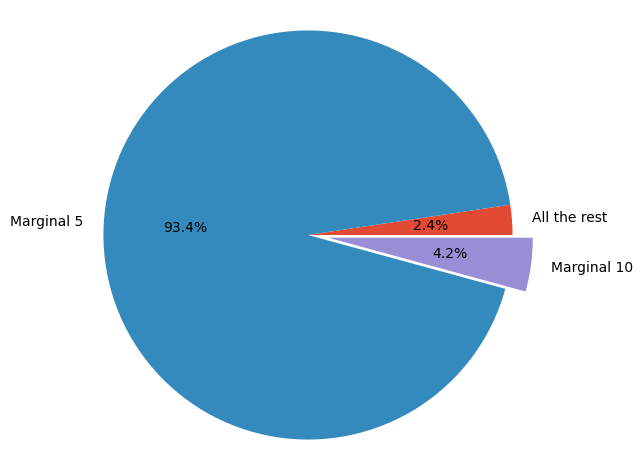

In [32]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

dic = {}
for i, v in enumerate(res["first order"]):
    dic["Marginal " + str(i+1)] = np.abs(v)

# group together all elements in the dictionary whose value is less than 2
# name this group 'All the rest'
import itertools
newdic={}
for key, group in itertools.groupby(dic, lambda k: 'All the rest' if (dic[k]<0.01) else k):
     newdic[key] = sum([dic[k] for k in list(group)])   

labels = newdic.keys()
sizes = newdic.values()

fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=(0,0,.1), startangle=0)
ax.axis('equal')
plt.tight_layout()

plt.show()

In [15]:
np.abs(res["total order"]) / np.abs(res["total order"]).sum()

array([1.16832038e-02, 2.60971948e-04, 1.48293121e-02, 2.50184560e-06,
       8.37179762e-01, 5.21577445e-03, 8.23303242e-03, 1.90610041e-05,
       1.12570153e-02, 1.11319365e-01])